<a href="https://colab.research.google.com/github/villamroland/EA/blob/master/lstm3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
plt.style.use('dark_background')
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, CuDNNLSTM, GlobalMaxPooling1D, SpatialDropout1D,Conv1D, MaxPooling1D, Flatten
import copy
from keras.optimizers import Adam
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

In [2]:
df_train = pd.read_csv('PJME_hourly.csv', sep=',')

print('train set: {0}'.format(df_train.shape))
df_train.head(10)

train set: (145366, 2)


,Datetime,PJME_MW
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0
5,2002-12-31 06:00:00,26222.0
6,2002-12-31 07:00:00,28702.0
7,2002-12-31 08:00:00,30698.0
8,2002-12-31 09:00:00,31800.0
9,2002-12-31 10:00:00,32359.0


In [0]:
df_train['Datetime']
df_train['Year'] = df_train['Datetime']
df_train['Month'] = df_train['Datetime']
df_train['Day'] = df_train['Datetime']
df_train['Hour'] = df_train['Datetime']

#for row in df_train.iterrows():


In [0]:
def getDays(dates):
    temp = []

    for i in range(0,len(dates)):
        temp.append((int)(''.join(dates[i].split(sep='-')[2]).split(sep=' ')[0]))

    return temp


def getMonths(dates):
    temp = []

    for i in range(0,len(dates)):
        temp.append((int)(dates[i].split(sep='-')[1]))

    return temp

def getYears(dates):
    temp = []

    for i in range(0,len(dates)):
        temp.append((int)(dates[i].split(sep='-')[0]))

    return temp

def getHours(dates):
    temp = []

    for i in range(0,len(dates)):
        temp.append((int)(''.join(''.join(dates[i].split(sep='-')[2]).split(sep=' ')[1])[0:2]))

    return temp

dates = copy.copy(df_train["Datetime"]) #converting date time

dates = dates.values

df_train.Day = getDays(dates)
df_train.Month=getMonths(dates)
df_train.Year=getYears(dates)
df_train.Hour = getHours(dates)
# for row in df_train.rows:
#   row['Year'] = row['Datetime']#[0:4] 
#   row['Month'] = row['Datetime']#[5:7]
#   row['Day'] = row['Datetime']#[8:10]
del df_train['Datetime']

In [5]:
df_train.head()

,PJME_MW,Year,Month,Day,Hour
0,26498.0,2002,12,31,1
1,25147.0,2002,12,31,2
2,24574.0,2002,12,31,3
3,24393.0,2002,12,31,4
4,24860.0,2002,12,31,5


In [0]:
from keras.layers import Dropout

def make_LSTM(window_size, filter_length, nb_input_series=1, nb_outputs=1, nb_filter=4):
  model = Sequential()
  model.add(LSTM(8, input_shape=(window_size, 5)))
  model.add(Dense(1))
  model.compile(loss='mean_squared_error', optimizer='adam')
  # model.fit(trainX, trainY, epochs=10, batch_size=8, verbose=1)
    # model = Sequential()
    # model.add(Conv1D(filters=nb_filter, kernel_size=filter_length, activation='relu', input_shape=(window_size, nb_input_series)))
    # model.add(MaxPooling1D())
    # model.add(Conv1D(filters=nb_filter, kernel_size=filter_length, activation='relu')) #########REGULARIZÁCIÓ!!!
    # #model.add(Conv1D(filters=nb_filter, kernel_size=filter_length, activation='relu'))
    # model.add(MaxPooling1D())
    # model.add(Conv1D(filters=nb_filter, kernel_size=filter_length, activation='relu'))
    # #model.add(Conv1D(filters=nb_filter, kernel_size=filter_length, activation='relu'))
    # model.add(MaxPooling1D())
    # model.add(Flatten())
    # model.add(Dense(16, activation='relu'))
    # model.add(Dense(16, activation='relu'))
    # model.add(Dense(1, activation='linear'))
    # model.compile(loss='mse', optimizer=Adam(lr=0.008), metrics=['mse'])
  model.metrics_names
  return model

In [7]:
X = df_train.values

window_size = 168   #96 volt az 1D-n
timeseries0 = copy.copy(X) #for the features
timeseries1 = copy.copy(X) #for the target
timeseries2 = copy.copy(X)

scaler = StandardScaler().fit(timeseries0) #normalizing
timeseries0 = scaler.transform(timeseries0)


timeseries0 = np.asarray(timeseries0)
assert 0 < window_size < timeseries0.shape[0] , "Out of range 0 < {} < {} ".format(window_size,timeseries0.shape[0])
X = np.array([timeseries0[start:start + window_size] for start in range(0, timeseries0.shape[0] - window_size)])


yVar,yMean = scaler.var_,scaler.mean_
#creating the inverse scaler for the target
import math
yVar = math.sqrt(yVar[0])
yMean = yMean[0]

print(yVar,yMean)

X = np.atleast_3d(X)
Y = timeseries0[window_size:]
Y = Y[:,0]

6463.989932797986 32080.222830648156


In [0]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

patience=3 #early stopping
early_stopping = EarlyStopping(patience=patience, verbose=1)
checkpointer = ModelCheckpoint(filepath='weightsd.hdf5', save_best_only=True, verbose=0)

In [10]:
filter_length = 2
nb_filter = 4

# timeseries = np.atleast_2d(timeseries)
# if timeseries.shape[0] == 1:
#     timeseries = timeseries.T       # 1D vektor -> 2D matrix
nb_samples, nb_series = timeseries2.shape
test_split = 0.1    #0.10 volt

# model = make_1d_convnet(window_size=window_size, filter_length=filter_length, nb_input_series=nb_series, nb_outputs=nb_series, nb_filter=nb_filter)
model = make_LSTM(window_size=window_size, filter_length=filter_length, nb_input_series=nb_series, nb_outputs=nb_series, nb_filter=nb_filter)

model.summary()

#X, Y = make_timeseries_instances(timeseries, window_size)

test_size = int(nb_samples*(1-test_split))
X_train, Y_train = X[:test_size], Y[:test_size]
#X_valid, Y_valid = X[valid_size:test_size], Y[valid_size:test_size]
X_test, Y_test   = X[test_size:], Y[test_size:]

history = model.fit(X_train, Y_train, epochs=25, batch_size=8, validation_split=0.2, shuffle=True,callbacks=[checkpointer, early_stopping], use_multiprocessing=True)

preds = model.predict(X_test)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 8)                 448       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9         
Total params: 457
Trainable params: 457
Non-trainable params: 0
_________________________________________________________________
Train on 104663 samples, validate on 26166 samples
Epoch 1/25
104663/104663 [==============================] - 1376s 13ms/step - loss: 0.0379 - val_loss: 0.0139
Epoch 2/25
104663/104663 [==============================] - 1370s 13ms/step - loss: 0.0122 - val_loss: 0.0122
Epoch 3/25
104663/104663 [==============================] - 1370s 13ms/step - loss: 0.0108 - val_loss: 0.0109
Epoch 4/25
104663/104663 [==============================] - 1373s 13ms/step - loss: 0.0101 - val_loss: 0.0114
Epoch 5/25
104663/104663 [=

In [11]:
from keras.models import load_model
from keras.optimizers import SGD
model = load_model('/content/weightsd.hdf5')
model.compile(loss='mse', optimizer=SGD(decay=0.00005), metrics=['mse'])
sgd_history = model.fit(X_train, Y_train, epochs=100, batch_size=32, validation_split=0.2, shuffle=True,callbacks=[checkpointer, early_stopping])

Train on 104663 samples, validate on 26166 samples
Epoch 1/100
104663/104663 [==============================] - 339s 3ms/step - loss: 0.0075 - mean_squared_error: 0.0075 - val_loss: 0.0087 - val_mean_squared_error: 0.0087
Epoch 2/100
104663/104663 [==============================] - 352s 3ms/step - loss: 0.0074 - mean_squared_error: 0.0074 - val_loss: 0.0087 - val_mean_squared_error: 0.0087
Epoch 3/100
104663/104663 [==============================] - 348s 3ms/step - loss: 0.0073 - mean_squared_error: 0.0073 - val_loss: 0.0087 - val_mean_squared_error: 0.0087
Epoch 4/100
104663/104663 [==============================] - 347s 3ms/step - loss: 0.0073 - mean_squared_error: 0.0073 - val_loss: 0.0087 - val_mean_squared_error: 0.0087
Epoch 5/100
104663/104663 [==============================] - 349s 3ms/step - loss: 0.0073 - mean_squared_error: 0.0073 - val_loss: 0.0087 - val_mean_squared_error: 0.0087
Epoch 6/100
104663/104663 [==============================] - 348s 3ms/step - loss: 0.0073 - me

In [0]:
preds = model.predict(X_test)

In [13]:
preds[20]

array([0.5447489], dtype=float32)

In [14]:
X_test[20,window_size-1,0]

0.5573611974659056

In [0]:
x_test_scaled = X_test*yVar+yMean
y_scaled = preds*yVar+yMean

In [16]:
x_test_scaled[40,window_size-1,0]

41249.0

In [17]:
y_scaled[40]

array([38556.977], dtype=float32)

In [18]:
timeseries1[23,0]

27008.0

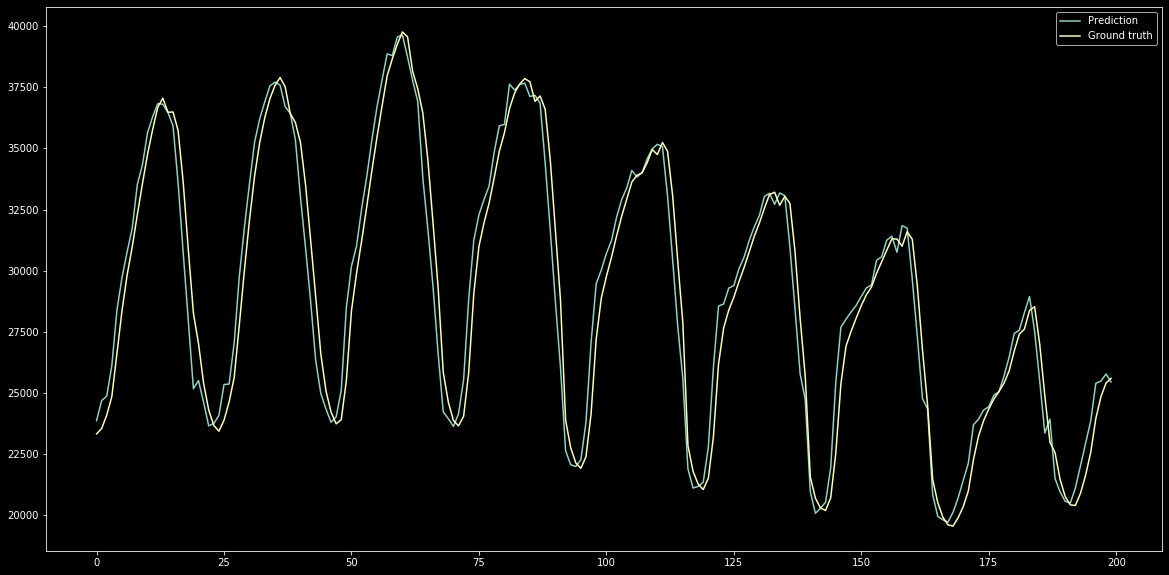

In [23]:
plt.figure(figsize=(20,10))
plt.plot(y_scaled[3000:3200])
plt.plot(x_test_scaled[3000:3200,-1,0])
plt.legend(['Prediction','Ground truth'])
plt.show()

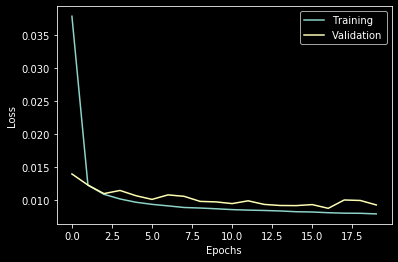

In [24]:
def plot_history(network_history):
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(network_history.history['loss'])
    plt.plot(network_history.history['val_loss'])
    plt.legend(['Training', 'Validation'])

plot_history(history)